In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
import seaborn as sn
import pickle

from tensorflow import convert_to_tensor
from sklearn.model_selection import train_test_split

pt.rcParams['figure.figsize'] = (5, 5)


In [20]:
original = pd.read_json('data/data.json')
original.iloc[:, 5:].describe()

,Best_Time,Completions,Time,3BV,3BV_Total,Clicks,Efficiency
count,6434.000000,6434.000000,6434.000000,6434.000000,6434.000000,6434.000000,6434.000000
mean,41.491975,7067.979950,93.341356,64.166926,64.166926,97.926018,68.896332
std,46.686911,11014.308408,417.369900,12.123854,12.123854,29.590954,17.958351
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.916750,515.250000,45.775250,56.000000,56.000000,80.000000,56.000000
50%,31.356000,2931.000000,60.711500,64.000000,64.000000,95.000000,68.000000
75%,42.767250,8959.250000,86.721500,72.000000,72.000000,112.000000,79.000000
max,1415.750000,170954.000000,25057.441000,107.000000,107.000000,731.000000,147.000000


In [21]:
df = pd.DataFrame()

# Board is a 256 character string, which we convert to a 16x16 matrix for CNN analysis

# Mines/Flags are converted to value 0 as each board has the same total number of bombs, 
# and overall difficulty of the board can be seen using the other cells.
df['Board'] = [np.reshape([int(j) if j not in 'bF' else 0 for j in original.loc[i, 'Board']], (16, 16)) for i in range(original.shape[0])]

df.loc[:, ['Best_Time', 'Completions', '3BV', 'Time']] = original.loc[:, ['Best_Time', 'Completions', '3BV', 'Time']]

# Best_Time, Time or 3BV being <= 0 indicates incomplete data
df = df[df['Best_Time'] > 0]
df = df[df['Time'] > 0]
df = df[df['3BV'] > 0]

# Normalized Speed is a metric used to eliminate outliers from the dataset.
# It normalizes the time taken to complete a board with the player's best time ever and the board's 3BV (which 
# roughly estimates the number of moves required to complete a board), which affects completion speed.

# Most players' best time is acheived on a board with very low 3BV, therefore the factor of 40 is chosen to 
# show how much faster a player was on this board compared to their best time.
# A Normalized Speed of 2 would mean the player completed the game twice as fast as expected
df['Normalized_Speed'] = (df['Best_Time'] / 40) / (df['Time'] / df['3BV'])

df.describe()

,Best_Time,Completions,3BV,Time,Normalized_Speed
count,6405.000000,6405.000000,6405.000000,6405.000000,6405.000000
mean,41.423446,7092.057923,64.396409,93.556701,0.858890
std,46.302565,11032.208985,11.521675,418.288810,0.282669
min,8.574000,1.000000,30.000000,12.735000,0.003444
25%,23.946000,523.000000,56.000000,45.804000,0.676234
50%,31.356000,2946.000000,64.000000,60.724000,0.848337
75%,42.765000,9058.000000,72.000000,86.753000,1.030083
max,1415.750000,170954.000000,107.000000,25057.441000,2.275000


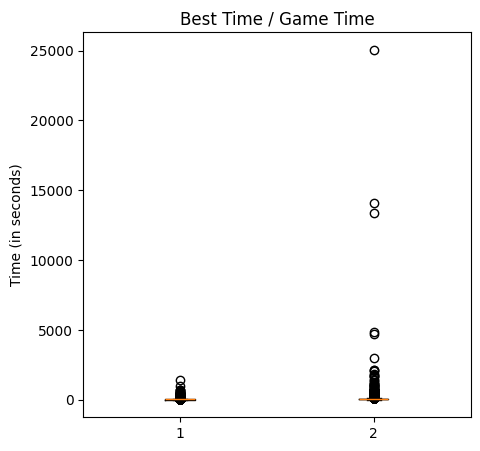

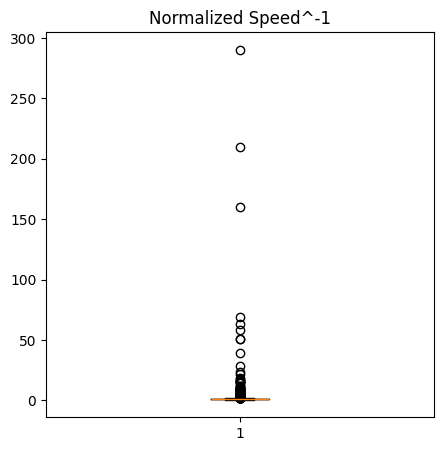

In [22]:
pt.title("Best Time / Game Time")
pt.ylabel('Time (in seconds)')
pt.boxplot(df.loc[:, ['Best_Time', 'Time']])
pt.show()

# Plotting the inverse of Normalized Speed as outliers in terms of speed are squished into a small region otherwise
pt.title("Normalized Speed^-1")
pt.boxplot(1/df['Normalized_Speed'])
pass

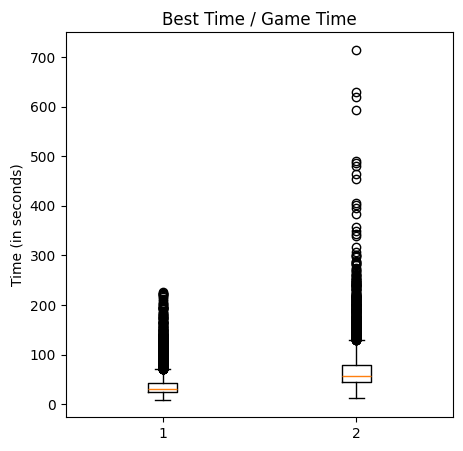

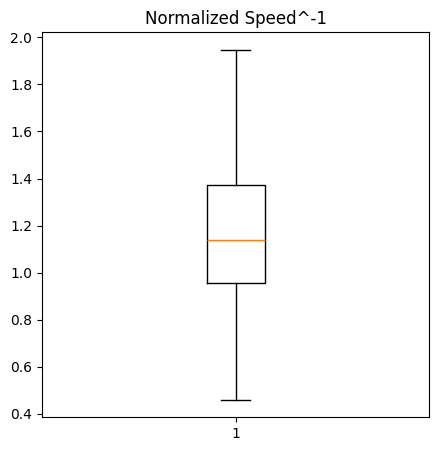

In [23]:
# Removing outliers
# Using Normalized Speed instead of Time to filter the datasets ensures that games are not filtered out 
# due to their relative difficulty but rather becuase the speed of completing the game was unnaturaly slow.
df = df[df['Best_Time'] <= df['Best_Time'].quantile(.99)]
df = df[df['Normalized_Speed'] >= df['Normalized_Speed'].quantile(.1)]


pt.title("Best Time / Game Time")
pt.ylabel('Time (in seconds)')
pt.boxplot(df.loc[:, ['Best_Time', 'Time']])
pt.show()

pt.title("Normalized Speed^-1")
pt.boxplot(1/df['Normalized_Speed'])
pass

In [24]:
df.describe()

,Best_Time,Completions,3BV,Time,Normalized_Speed
count,5706.000000,5706.000000,5706.000000,5706.000000,5706.000000
mean,38.528837,6966.896250,64.782334,68.822959,0.906308
std,25.706327,11021.156125,11.409313,43.774572,0.235468
min,8.690000,1.000000,30.000000,12.735000,0.513586
25%,24.089000,506.000000,57.000000,44.361250,0.728558
50%,31.448000,2874.500000,64.000000,57.406000,0.878881
75%,42.761250,8563.250000,72.000000,78.537000,1.046684
max,226.134000,170954.000000,107.000000,715.012000,2.175000


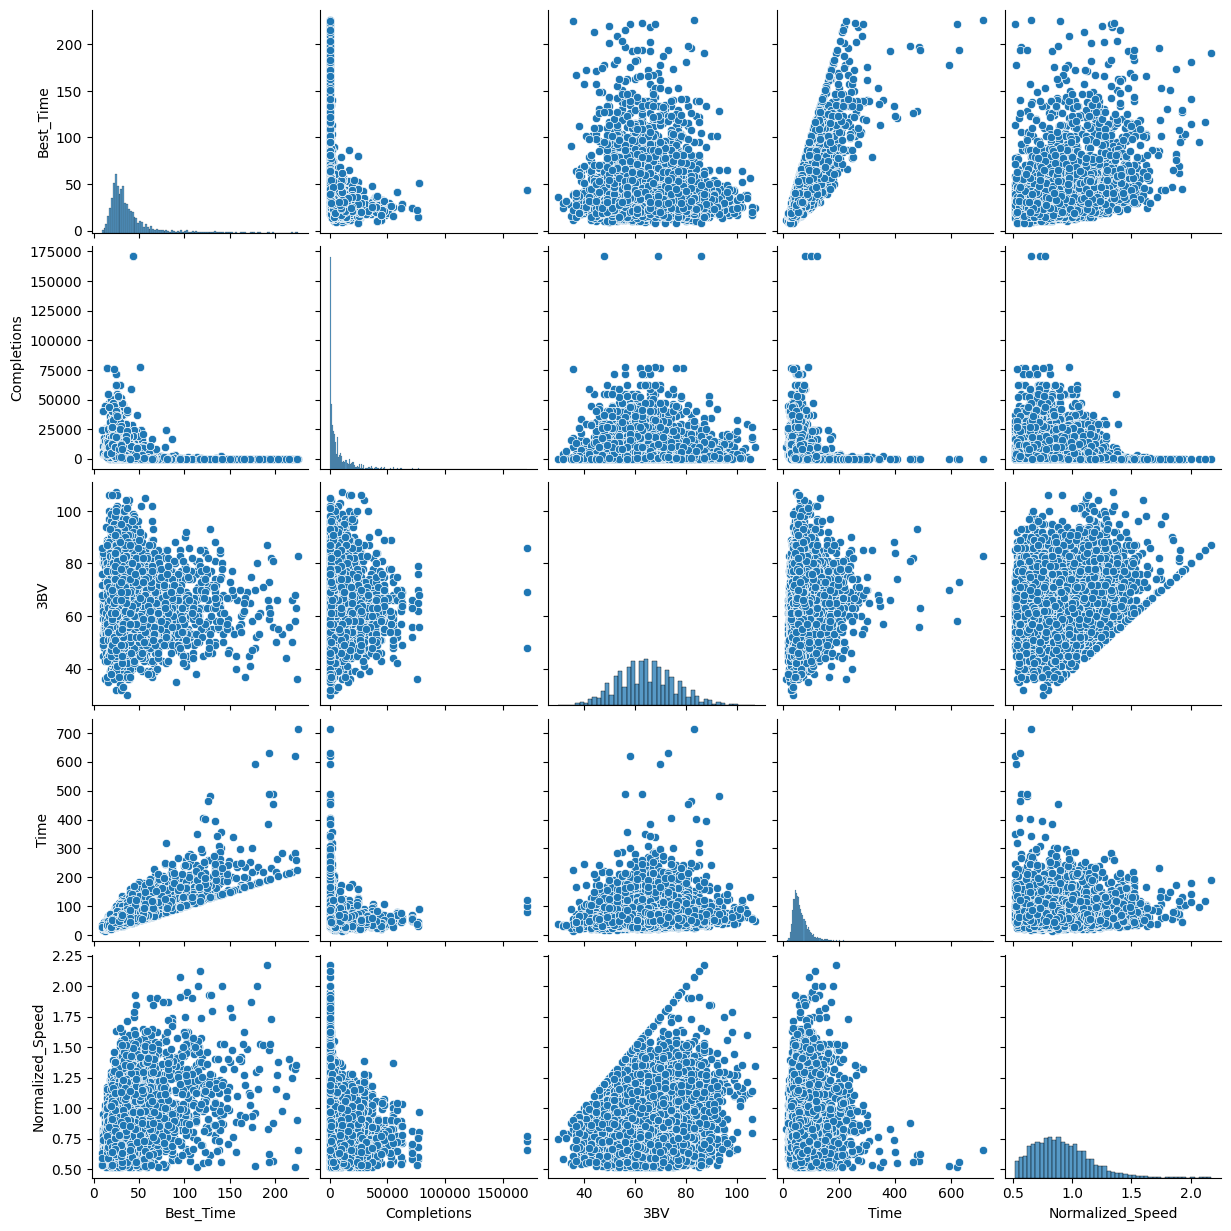

In [25]:
sn.pairplot(df.iloc[:, 1:])

In [26]:
# Normalized speed depends on 3BV, which is an imperfect metric to judge difficulty
# Therefore, it was only used for outlier detection and will not be used henceforth

final = df.drop(columns = ['Normalized_Speed', '3BV'])
#final['Board'] = [convert_to_tensor(i) for i in df.iloc[:, 0]]
final

,Board,Best_Time,Completions,Time
0,"[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",34.846,5499,55.668
1,"[[0, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,...",42.400,1320,70.152
2,"[[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,...",18.242,191,31.689
5,"[[0, 1, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2,...",40.095,823,48.238
6,"[[0, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1,...",38.206,267,58.545
...,...,...,...,...
6428,"[[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,...",54.875,555,93.827
6429,"[[1, 0, 1, 0, 1, 0, 2, 2, 1, 1, 0, 0, 1, 0, 0,...",31.009,7845,67.260
6430,"[[0, 0, 0, 1, 3, 0, 3, 1, 2, 0, 1, 0, 1, 0, 1,...",39.918,585,43.450
6431,"[[0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1,...",47.020,2497,119.337


In [32]:
x = final.iloc[:, :-1]
y = final.iloc[:, -1] 
#x.iloc[:, 0] = np.array([convert_to_tensor(i) for i in x.iloc[:, 0]])

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.2, random_state = 0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 0)

with open('data/x_train.pkl', 'wb') as f:
    pickle.dump(x_train, f)

with open('data/y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

with open('data/x_val.pkl', 'wb') as f:
    pickle.dump(x_val, f)

with open('data/y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)

with open('data/x_test.pkl', 'wb') as f:
    pickle.dump(x_test, f)

with open('data/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

print(f'''
x_train: {x_train.shape}
x_val: {x_val.shape}
x_test: {x_test.shape}

y_train: {y_train.shape}
y_val: {y_val.shape}
y_test: {y_test.shape}''')


x_train: (4564, 3)
x_val: (571, 3)
x_test: (571, 3)

y_train: (4564,)
y_val: (571,)
y_test: (571,)
